In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import tqdm
import os
from PIL import Image

from scipy.fft import fft2

In [2]:
VIDEO_EXTENSIONS = ['mov', 'avi', 'mp4']
IMAGE_EXTENSIONS = ['jpg', 'png', 'tif']

def loadImages(path, n=None):
    if path[-3:].lower() in VIDEO_EXTENSIONS:
        return getVideoFrames(path)
    
    elif os.path.isdir(path):
        images = []
        #images = [cv2.imread(path + '/' + f) for f in os.listdir(path)[:None] if f[-3:] in IMAGE_EXTENSIONS]
        for f in np.sort(os.listdir(path)[:n]):
            if f[-3:].lower() in IMAGE_EXTENSIONS:
                images.append(cv2.imread(path + '/' + f))
            
        return images


def getVideoFrames(videoPath):
    cam = cv2.VideoCapture(videoPath)

    frames = []

    while(True):
        ret, frame = cam.read()

        if ret:
            frames.append(frame.astype(np.uint8))

        else:
            break

    return frames


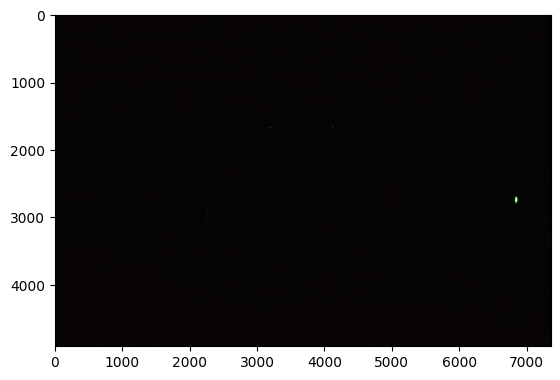

In [3]:
#videoPath = '/home/jack/Videos/Web Scanning/2023-02-22_Test_Laser1.MOV'
videoPath = '/home/jack/Videos/Web Scanning/2023-02-27_Test_Burst_Laser2/'

videoFrames = loadImages(videoPath, n=2)
#print(videoFrames)

#regionOfInterest = [[None,None], [None,None]]

#regionOfInterest = [[300, 900], # y
#                    [400, 1300]] # x

#videoFrames = [v[regionOfInterest[0][0]:regionOfInterest[0][1],regionOfInterest[1][0]:regionOfInterest[1][1]] for v in videoFrames]

plt.imshow(videoFrames[0])
plt.show()

In [4]:
fps = 20
skip = 2
loop = 0

imgArr = [Image.fromarray(v) for v in videoFrames[::skip]]

imgArr[0].save(f'images/2023-02-09_cropped.gif', save_all=True, append_images=imgArr[1:], duration=fps, loop=loop)

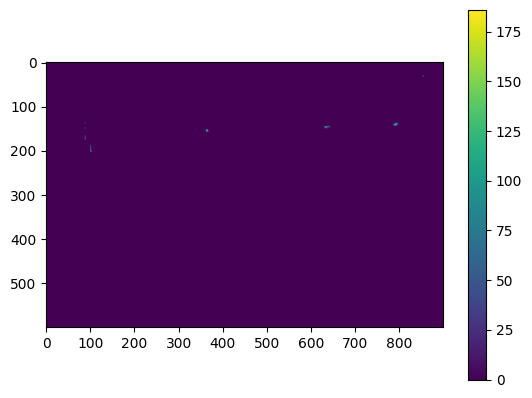

In [4]:
threshold = 30

thresholdFrames = np.zeros((len(videoFrames), *videoFrames[0].shape[:2]))

for i in range(len(thresholdFrames)):
    thresholdFrames[i] = videoFrames[i][:,:,1]
    thresholdFrames[i][np.where(thresholdFrames[i] < threshold)] = 0
    
plt.imshow(thresholdFrames[100])
plt.colorbar()
plt.show()

In [5]:
fps = 20
skip = 2
loop = 0

imgArr = [Image.fromarray(v) for v in thresholdFrames[::skip]]

imgArr[0].save(f'images/2023-02-22_threshold.gif', save_all=True, append_images=imgArr[1:], duration=fps, loop=loop)

In [5]:
frameSpacing = 1

scatterPoints = []

for i in range(len(thresholdFrames)):
    planarPoints = np.array(np.where(thresholdFrames[i] > 0)).T
    
    scatterPoints += [(*p, frameSpacing*i) for p in planarPoints]
    
scatterPoints = np.array(scatterPoints)

In [11]:
images = []

fps = 20
loop = 0
dsFactor = 8

for i in tqdm.tqdm(range(360)):
    fig = plt.figure(figsize=(7,7))

    ax = fig.add_subplot(projection='3d')

    ax.scatter(scatterPoints[::dsFactor,2], scatterPoints[::dsFactor,1], scatterPoints[::dsFactor,0], s=.2)
    ax.set_zlim([0, regionOfInterest[0][1] - regionOfInterest[0][0]])
    ax.set_ylim([0, regionOfInterest[1][1] - regionOfInterest[1][0]])
    ax.view_init(-160, i)
    
    fig.tight_layout()
    canvas = plt.get_current_fig_manager().canvas
    canvas.draw()

    images.append(Image.frombytes('RGB', canvas.get_width_height(),
                 canvas.tostring_rgb()))
    
    #plt.show()
    plt.close()

images[0].save(f'images/2023-02-22_laser1_thread_scatter.gif', save_all=True, append_images=images[1:], duration=fps, loop=loop)

100%|████████████████████████████████████████████████████████| 360/360 [02:19<00:00,  2.58it/s]


In [6]:
len(scatterPoints)

188721

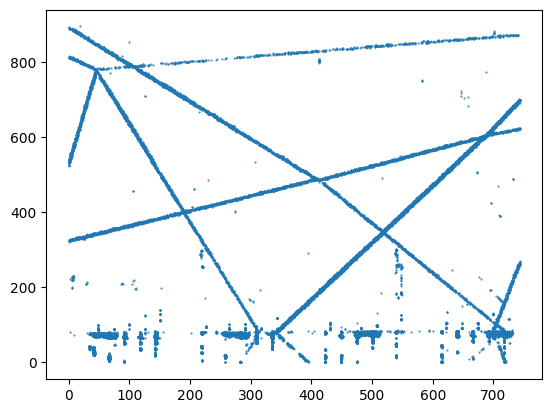

In [14]:
plt.scatter(scatterPoints[::dsFactor,2], scatterPoints[::dsFactor,1], s=.2)
plt.show()

In [15]:
with open('2d_web.npy', 'wb') as f:
    np.save(f, scatterPoints)